In [33]:
import pandas as pd
from pymongo import MongoClient
from apyori import apriori
import seaborn as sns
from wordcloud import WordCloud
from config import DB
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [59]:
client = MongoClient(DB.MONGO_URL)
db = client["adtProject"]
df1 = pd.DataFrame(db["restaurant-1-orders"].find({}))
df2 = pd.DataFrame(db["restaurant-2-orders"].find({}))

In [60]:
df1 = df1.rename(columns={'Order Number': 'Order ID'})

In [61]:
df1.shape

(74818, 7)

In [62]:
df2.shape

(119183, 7)

In [63]:
df = pd.concat([df1, df2])


(194001, 8)

In [64]:
df.dtypes

_id               object
Order id          object
Order Date        object
Item Name         object
Quantity          object
Product Price     object
Total products    object
Order Number      object
dtype: object

In [65]:
df['Item Name'].nunique()

381

In [66]:
transformedDF = (df.groupby('Order id').head(len(df))
   .groupby('Order id')['Item Name'].agg(list)
).reset_index()
transformedDF

,Order id,Item Name
0,10000,"[Plain Rice, Royal Paneer, Aloo Gobi, Saag Alo..."
1,10001,"[Bombay Aloo, Dupiaza - Chicken, King Prawn Bi..."
2,10002,"[Garlic Naan, Paratha, Aloo Chaat, Sheek Kebab..."
3,10003,"[Bottle Diet Coke, Saag Paneer, Lamb Tikka Mas..."
4,10004,"[Saag Rice, Chicken Roshni]"
...,...,...
13392,9995,"[Mint Sauce, Plain Papadum, Plain Naan, Pilau ..."
13393,9996,"[Plain Naan, Pilau Rice, Madras - Chicken Tikk..."
13394,9997,"[Paratha, Garlic Naan, Prawn Puree, Tarka Dall..."
13395,9998,"[Onion Chutney, Meat Samosa, Tandoori Chicken ..."


In [67]:
df = pd.DataFrame([x for x in transformedDF['Item Name']])
# df.columns = [x for x in df.columns]
df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,Plain Rice,Royal Paneer,Aloo Gobi,Saag Aloo,Chicken Tikka Balti,Prawn Balti,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Bombay Aloo,Dupiaza - Chicken,King Prawn Biryani,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Garlic Naan,Paratha,Aloo Chaat,Sheek Kebab (Main),Paneer Tikka Karahi,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Bottle Diet Coke,Saag Paneer,Lamb Tikka Masala,Lamb Tikka (Main),None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Saag Rice,Chicken Roshni,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13392,Mint Sauce,Plain Papadum,Plain Naan,Pilau Rice,Saag Aloo,Madras - Chicken,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13393,Plain Naan,Pilau Rice,Madras - Chicken Tikka,Chicken Tikka (Main),None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13394,Paratha,Garlic Naan,Prawn Puree,Tarka Dall,Saag - Prawn,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13395,Onion Chutney,Meat Samosa,Tandoori Chicken (1/4),Saag Dall,Lamb Tikka Chilli Masala,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


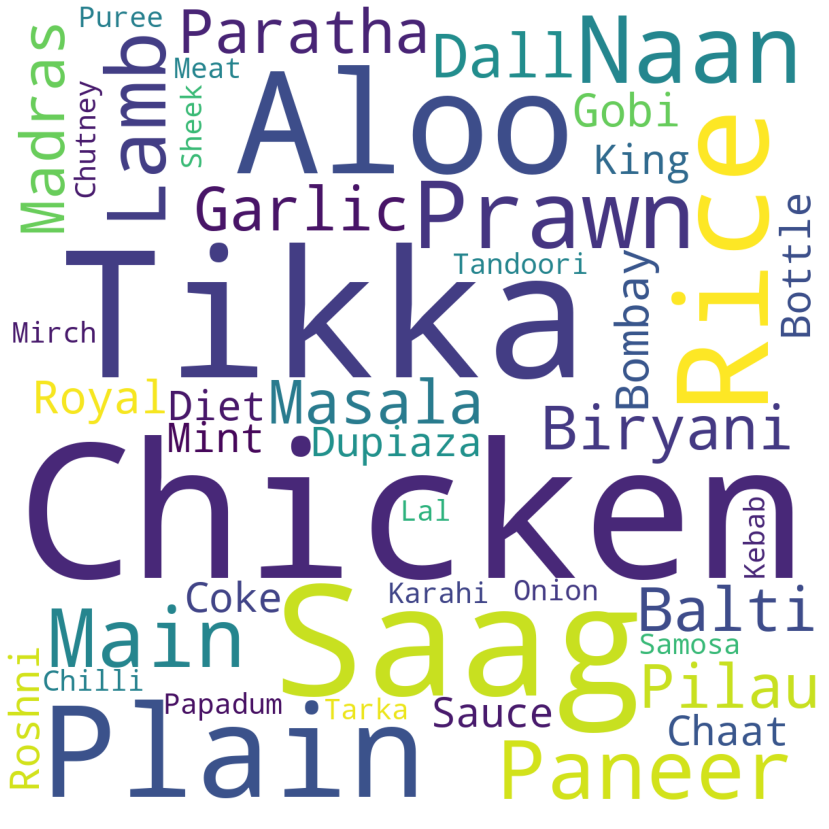

In [112]:
inp = str(df).replace('None', '')
inp = inp.replace("columns", "")
inp = inp.replace("rows", "")
inp = inp.replace("x", "")
plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 100).generate(inp)
plt.imshow(wordcloud)
plt.axis('off')
# plt.title('Most Popular Items',fontsize = 20)
plt.show()

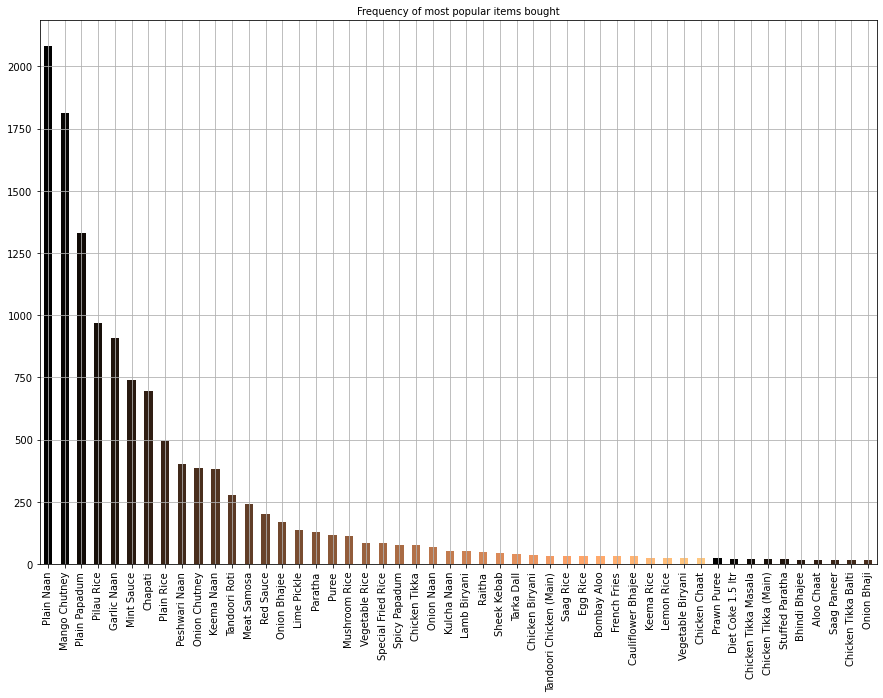

In [88]:
plt.rcParams['figure.figsize'] = (15, 10)
color = plt.cm.copper(np.linspace(0, 1, 40))
df[0].value_counts().head(50).plot.bar(color = color)
plt.title('Frequency of most popular items bought', fontsize = 10)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [92]:
dim = df.shape
rows = dim[0]
cols = dim[1]
transactions = []
for i in range(0, rows):
    transactions.append([str(df.values[i,j]) for j in range(0, cols)])

In [93]:
rule_list = apriori(transactions, min_support = 0.003, min_confidence = 0.1, min_lift = 3, min_length = 2)
results = list(rule_list)


In [94]:
bought_item = [tuple(result[2][0][0])[0] for result in results]
will_buy_item = [tuple(result[2][0][1])[0] for result in results]
support_values = [result[1] for result in results]
confidences = [result[2][0][2] for result in results]
lift_values = [result[2][0][3] for result in results]

In [100]:
op = pd.DataFrame(list(zip(bought_item, will_buy_item, support_values, confidences, lift_values)), columns = ['Bought Item', 'Expected To Be Bought', 'Support', 'Confidence', 'Lift'])
op

,Bought Item,Expected To Be Bought,Support,Confidence,Lift
0,Aloo Chaat,Vegetable Roll,0.003508,0.165493,7.752130
1,Aloo Gobi,Tandoori Roti,0.005150,0.112195,3.310745
2,Vegetable Biryani,Aloo Gobi,0.003658,0.153125,3.335635
3,Bhuna,Saag Bhajee,0.003732,0.107296,6.195889
4,Bhuna - Chicken Tikka,Mushroom Rice,0.003135,0.328125,3.027473
...,...,...,...,...,...
1943,Mango Chutney,Mint Sauce,0.003284,0.107579,11.622920
1944,Red Sauce,Saag Aloo,0.003732,0.148368,19.487112
1945,Red Sauce,Plain Papadum,0.003284,0.130564,15.078993
1946,Mint Sauce,Plain Papadum,0.003807,0.136364,14.272372


In [ ]:
db['rules'].delete_many({})
for i in range(len(bought_item)):
    db['rules'].insert_one({
        "_id": i,
        "Bought Item":bought_item[i],
        "Expected To Be Bought":will_buy_item[i],
        "Support":support_values[i],
        "Confidence":confidences[i],
        "Lift":lift_values[i],
     })